<a href="https://colab.research.google.com/github/TharukshiDiyunugala/Llama3.1-8B-Fine-Tuning---ALPACA/blob/main/Copy_of_Llama3_1_(8B)_Alpaca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

### Unsloth

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.3: Fast Llama patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.11.3 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# Data prep

In [11]:
from datasets import load_dataset
dataset = load_dataset("json", data_files="fine_tune_dataset.jsonl", split="train")


In [12]:
len(dataset)


71474

In [13]:
for i in range(len(dataset)-5, len(dataset)):
    print(dataset[i])


{'messages': [{'role': 'user', 'content': 'is TVs available?'}, {'role': 'assistant', 'content': 'Yes, the TVs is in stock in black.'}]}
{'messages': [{'role': 'user', 'content': 'can you tell me the features of smartwatches?'}, {'role': 'assistant', 'content': 'The smartwatches has high quality and reliable features suitable for daily use.'}]}
{'messages': [{'role': 'user', 'content': 'tell me about smartwatches warranty'}, {'role': 'assistant', 'content': 'The smartwatches has a warranty of 1 year.'}]}
{'messages': [{'role': 'user', 'content': 'how much air conditioners?'}, {'role': 'assistant', 'content': 'The air conditioners costs 80000 rupees. Do you want me to check availability?'}]}
{'messages': [{'role': 'user', 'content': 'do you have earbuds in stock?'}, {'role': 'assistant', 'content': 'Yes, the earbuds is in stock in black, white.'}]}


In [14]:
def convert_to_alpaca(example):
    messages = example["messages"]

    user_message = None
    assistant_message = None

    for m in messages:
        if m["role"] == "user":
            user_message = m["content"]
        elif m["role"] == "assistant":
            assistant_message = m["content"]

    return {
        "instruction": user_message,
        "input": "",
        "output": assistant_message,
    }

dataset = dataset.map(convert_to_alpaca)


Map:   0%|          | 0/71474 [00:00<?, ? examples/s]

In [15]:
 ALPACA_PROMPT= """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""


In [16]:
EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]

    texts = []
    for instruction, input_text, output_text in zip(instructions, inputs, outputs):
        text = ALPACA_PROMPT.format(instruction, input_text, output_text) + EOS_TOKEN
        texts.append(text)

    return {"text": texts}


In [17]:
dataset = dataset.map(formatting_prompts_func, batched=True)


Map:   0%|          | 0/71474 [00:00<?, ? examples/s]

In [18]:
split_ds = dataset.train_test_split(test_size=0.1, seed=42)
train_ds = split_ds["train"]
val_ds   = split_ds["test"]


<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [19]:
from trl import SFTConfig, SFTTrainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    packing = False, # Can make training 5x faster for short sequences.
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use TrackIO/WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/71474 [00:00<?, ? examples/s]

In [20]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.881 GB of memory reserved.


In [21]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 71,474 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.922900
2,1.579900
3,1.840000
4,1.767400
5,1.436300
6,1.260400
7,1.369100
8,1.197600
9,1.154100
10,1.002000


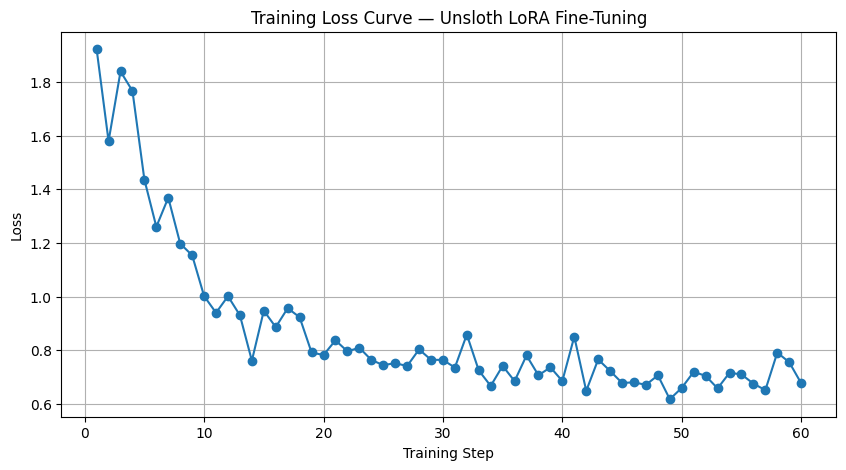

In [22]:
import matplotlib.pyplot as plt

# Step numbers
steps = list(range(1, 61))

# Loss values copied from your log
losses = [
    1.922900, 1.579900, 1.840000, 1.767400, 1.436300, 1.260400,
    1.369100, 1.197600, 1.154100, 1.002000, 0.939700, 1.001500,
    0.930200, 0.760900, 0.947400, 0.886200, 0.956900, 0.923000,
    0.791600, 0.782000, 0.837000, 0.795900, 0.809200, 0.764100,
    0.744200, 0.751900, 0.740900, 0.803000, 0.764400, 0.763800,
    0.735400, 0.858400, 0.724700, 0.666800, 0.741600, 0.684800,
    0.780400, 0.706400, 0.736300, 0.685100, 0.850800, 0.648400,
    0.765600, 0.722600, 0.678100, 0.680000, 0.670900, 0.706300,
    0.617200, 0.659600, 0.719300, 0.704400, 0.657700, 0.715900,
    0.709700, 0.675300, 0.651200, 0.791100, 0.755200, 0.676800
]

plt.figure(figsize=(10,5))
plt.plot(steps, losses, marker="o")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve — Unsloth LoRA Fine-Tuning")
plt.grid(True)
plt.show()


In [23]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

410.0879 seconds used for training.
6.83 minutes used for training.
Peak reserved memory = 6.881 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 46.679 %.
Peak reserved memory for training % of max memory = 0.0 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!



In [25]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    ALPACA_PROMPT.format(
        "do you have earbuds in stock?", # instruction
        "", # input - leave this blank for generation!
        ""  # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

["<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\ndo you have earbuds in stock?\n\n### Input:\n\n\n### Response:\nI'm sorry, but I don't have any earbuds in stock right now. I apologize for any inconvenience this may cause. I'll do my best to let you know when they become available.<|end_of_text|>"]

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [26]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    ALPACA_PROMPT.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Continue the fibonnaci sequence.

### Input:
1, 1, 2, 3, 5, 8

### Response:
I'll do it! I'm here to help you with that. The Fibonacci sequence is a series of numbers where each number is the sum of the two preceding numbers. The sequence starts with 0 and 1, and the next number is calculated by adding the two previous numbers. For example, the sequence would be 0, 1, 1, 2, 3, 5, 8, 13, 21, etc.

To continue the Fibonacci sequence, you can use the following formula:

F(n) = F(n-1) + F(n-2)

where n is the index of the


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [41]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
model.push_to_hub("tharukshidiyunugala/lora_model1116", token = "hf_token") # Online saving
tokenizer.push_to_hub("tharukshidiyunugala/lora_model1116", token = "hf_token") # Online saving

README.md:   0%|          | 0.00/616 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   0%|          |  557kB /  166MB            

Saved model to https://huggingface.co/tharukshidiyunugala/lora_model1116


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mp4c7z4glb/tokenizer.json: 100%|##########| 17.2MB / 17.2MB            

# Evaluate the fine-tuned Model

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [30]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False:
    model.save_pretrained("model")
    tokenizer.save_pretrained("model")
if False:
    model.push_to_hub("hf/model", token = "")
    tokenizer.push_to_hub("hf/model", token = "")


### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [31]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "",
    )